# Kaggle Competition - Dog Breed Identifcation
### Matthew Lindow
#### A01875594
Determine the breed of a dog in an image

https://www.kaggle.com/c/dog-breed-identification/

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import io
import os
import shutil
import time
from copy import deepcopy
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.utils.data as data

device = 'cuda'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
from google.colab import files
uploaded = files.upload()

Saving labels.csv to labels.csv


In [4]:
labels = pd.read_csv(io.BytesIO(uploaded['labels.csv']))

In [ ]:
# !unzip /content/gdrive/MyDrive/test.zip -d /content/gdrive/MyDrive/test
# !unzip /content/gdrive/MyDrive/train.zip -d /content/gdrive/MyDrive/train

In [7]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(20),
     transforms.Resize(size=(150,150)),
     transforms.ColorJitter(hue=.001, saturation=.001),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

train_data_path = "/content/gdrive/MyDrive/train"
test_data_path = "/content/gdrive/MyDrive/test"

train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
testset = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
quarter = len(train_data) // 4
trainset, valset = random_split(train_data, [len(train_data) - quarter, quarter])

valloader = data.DataLoader(valset, batch_size=batch_size, shuffle=True,  num_workers=4)
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True,  num_workers=4)
testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=True,  num_workers=4)

In [8]:
print("Number of train samples: ", len(trainset))
print("Number of validation samples: ", len(valset))
print("Number of test samples: ", len(testset))

Number of train samples:  7667
Number of validation samples:  2555
Number of test samples:  10357


In [9]:
# labels.head()
classes = labels['breed'].to_list()
print("Number of breeds: ", len(classes))

Number of breeds:  10222


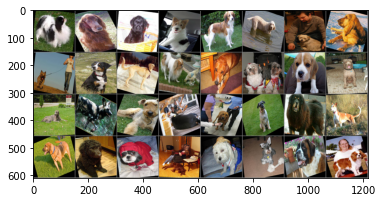

boston_bull boston_bull boston_bull boston_bull


In [10]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

net = models.resnet34(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [18]:
%%time
best_val_acc = -1000
best_val_model = None
for epoch in range(10):  
    net.train()
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")
    
    correct = 0
    net.eval()
    with torch.no_grad():
        for inputs,labels in valloader:
            out = net(inputs.cuda()).cpu()
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(valset)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(net.state_dict())
    lr_scheduler.step()
    if running_acc*100/len(trainset) == float(100) and correct*100/len(valset) == float(100):
      break
    
print('Finished Training')  

Train loss 1: 0.0,Train Acc:100.0%
Val accuracy:100.0%
Finished Training
CPU times: user 12.1 s, sys: 2.9 s, total: 15 s
Wall time: 1min 13s


In [14]:
%%time
correct = 0
net.load_state_dict(best_val_model)
net.eval()
with torch.no_grad():
    for inputs,labels in testloader:
        out = net(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        
        correct += acc
print(f"Test accuracy: {correct*100/len(testset)}%")

Test accuracy: 100.0%
CPU times: user 8.68 s, sys: 4.83 s, total: 13.5 s
Wall time: 9min 14s
